---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [76]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


class BlightDataset():
    
    def __init__(self, dataname = 'train.csv', 
                 verbose = False,
                 initial_features = None, X = None):
        
        self.verbose=verbose
        
        self._df = None
        if not (dataname is None):
            self._raw_df = pd.read_csv(dataname, encoding='latin1')
            
            # data frame that will be modified
            self.df = self._raw_df.copy()
        
  #      else if not (X is None):
            # do filtering
            
   #     else:
            
        # features used to fit the model    
        if initial_features is None:
            initial_features = ['late_fee',
                         # 'agency_name',
                         #' discount_amount',
                         # 'zip_code',
                         # 'violation_code',
                         # 'hearing_date', 
                         # 'ticket_issued_date',
                         'fine_amount',
                         'disposition']
        
        self.initial_features = initial_features
        self.features         = initial_features.copy()     
        self.target = 'compliance'
        
        return
    
    @property
    def raw_df(self):
        """
        Original dataframe of associated dataset.
        Read-only.
        """
        return self._raw_df.copy()
    
    
    def clean_data(self, df = None, 
                         remove_null_compliance=True):
        """
        This goes through and removes all unneeded data
        and cleans features.
        
        remove_null_compliance : if true, removes null compliance
                                 values from dataset
                                 if false, treats these as compliant
                                
        """
        
            
        # can optionally pass a df to be filtered
        # otherwise, uses self
        df_none = False
        if df is None:
            df = self.df.copy()
            df_none = True
        else:
            df = df.copy()
            
        training_data = self.target in df.columns

        # zip code
        #         convert < 5 to Null values
        #         convert > 5 to just first 5 digits
        df['zip_code'] = [str(x) if len(str(x)) == 5 else str(x)[:5] if len(str(x)) > 5 else 'nan' for x in df['zip_code']]        
        df['zip_code'] = [x if x.isdecimal() else 'nan' for x in df['zip_code']]
        df['zip_code'] = df['zip_code'].astype(str).replace('nan','0').astype(float)
        
        
        # violation code
        #if 'violation_code' in self.initial_features:
        #    df['violation_code'] = self.violation_code_mapper(df['violation_code'].astype('str'))
        
        # agency name
        if 'agency_name' in self.initial_features:
            df = self.agency_name_encoding(df,append_features=training_data)
        
        # hearing date
        # convert to year with decimals
        df['hearing_date'] = df['hearing_date'].astype(str)
        # date as fraction of month conversion is not strictly correct here (assumes 31 days each month)
        # but the effect does not matter vs. a more accurate decimal
        df['hearing_date']  = np.array([float(x[:4]) + float(x[5:7])/12.0 + float(x[9:11])/31.0 if x != 'nan' else 0.0 for x in df['hearing_date']])
        
        
        df['ticket_issued_date'] = df['ticket_issued_date'].astype(str)
        # date as fraction of month conversion is not strictly correct here (assumes 31 days each month)
        # but the effect does not matter vs. a more accurate decimal
        df['ticket_issued_date']  = np.array([float(x[:4]) + float(x[5:7])/12.0 + float(x[9:11])/31.0 if x != 'nan' else 0.0 for x in df['ticket_issued_date']])
               
        if 'hearing_date' in self.initial_features and 'ticket_issued_date' in self.initial_features:
            df['hearing_ticket_diff'] = df['hearing_date'] - df['ticket_issued_date']
            if training_data:
                self.features.append('hearing_ticket_diff')

        #
        # just keep this the same for now,
        # but it MIGHT be good to 
        #       
        df['judgment_amount'] = df['judgment_amount'].astype(float).fillna(-1.0)
        
        #
        #  Disposition - 
        #     Strong correlation for some of these categories, but group
        #     the similar ones together to reduce number of new features
        #     Not responsibles are all the same, pending are the same,
        #     responsible_ad behave the same
        #
        #
        if 'disposition' in self.initial_features:
            df['disposition'] = ['Not Responsible' if (('Not Responsible' in x) or ('Not responsible' in x)) else x for x in df['disposition'].astype(str)]
            df['disposition'] = ['Pending' if 'PENDING' in x else x for x in df['disposition']]
            df['disposition'] = ['Responsible AD' if (('Responsible' in x) and (('Admission' in x) or ('Determination' in x))) else x for x in df['disposition']]
            df = self.disposition_encoding(df, append_features=training_data)
        
        
     
        #
        # Processing on target field
        #
        if training_data:
            # df[self.target_field] = df[self.target_field].astype(int)
            if not remove_null_compliance:
                df[self.target].fillna(1.0, inplace=True)
                         
        if training_data:
            df = self.remove_data_for_training(df, remove_null_compliance=remove_null_compliance)
        
        # print(df.columns)

        if df_none:
            self.df = df
                
        
        #for k in X.columns:
        #    print(k, np.sum(X[k].isnull()), X[k][X[k].isnull()])

        
        if training_data:
                    
            self.y_train = self.df[self.target]
            self.X_train = self.df[self.features]
            
            return self.X_train, self.y_train
        
        else:
            
            # for columns NOT here, need to fill with zeros
            for xname in self.X_train.columns:
                if not (xname in df.columns):
                    df[xname] = np.zeros(len(df))
                    
            X = df[self.features]
            
            return X
        
        
    def train_model(self, X_train, y_train, grid_search=False):
        """
        Model training.
        """
        # try with defaults for now!
        
        self.X_train = X_train
        self.y_train = y_train
        
        
        if grid_search:
            parameters = {
                #"loss":["deviance"],
                "learning_rate": [ 0.1],
                #"min_samples_split": np.linspace(0.1, 2, 4),
               # "min_samples_leaf": np.linspace(0.1, 1, 4),
                "max_depth":[5],
                "max_features":["log2","sqrt"],
                #"criterion": ["friedman_mse",  "mae"],
                "subsample":[0.5, 0.75, 0.9, 1.0],
                "n_estimators":[500]
                }

            grid_clf = GridSearchCV(GradientBoostingClassifier(), parameters, 
                                    cv=3, n_jobs=4, scoring='roc_auc')
            
            grid_clf.fit(X_train, y_train)

            if self.verbose:
                print(grid_clf.best_params_)
            
            model_parameters = grid_clf.best_params_
        else:
            model_parameters = {'learning_rate':0.1, 
                                'max_depth' : 5,
                                'n_estimators' : 500}            
        
        clf = GradientBoostingClassifier(**model_parameters)
        clf.fit(X_train, y_train)
        
        self.clf = clf
        
        
        self.train_auc      = roc_auc_score(y_train, self.clf.predict_proba(X_train)[:,1])        
        self.train_accuracy = self.clf.score(X_train, y_train)
        
        if self.verbose:
            print("Classifier Training AOC: %5.5f"%(self.train_auc))
            print("Classifier Training Accuracy: %5.5f"%(self.train_accuracy))
        
        #return self.train_auc, self.train_accuracy        
        return        
        
    def train_dummy(self, X_train, y_train):
        """
        Dummy classifier
        """
        from sklearn.dummy import DummyClassifier

        dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
        y_dummy_predictions = dummy_majority.predict(X_train)

        self.dummy_clf = dummy_majority
        
        self.dummy_auc      = roc_auc_score(y_train, self.dummy_clf.predict_proba(X_train)[:,1])        
        self.dummy_accuracy = self.dummy_clf.score(X_train, y_train)
        
        if self.verbose:
            print("Dummy Classifier Training AOC: %5.5f"%(self.dummy_auc))
            print("Dummy Classifier Training Accuracy: %5.5f"%(self.dummy_accuracy))
        
        return self.dummy_auc, self.dummy_accuracy
                    
    def remove_data_for_training(self, df = None, 
                                       remove_null_compliance=False):
        """
        All editing is done in-place on dataframe
        """
             
        df_none = False
        if df is None:
            df_none = True
            df = self.df.copy()
        #
        # Now remove rows
        #
        mask = np.ones(len(df)).astype(bool)
        
        if remove_null_compliance and 'compliance' in df.columns:
            mask = mask * df['compliance'].notnull()
        
        
        df = df[mask]
        
        if df_none:
            self.df = df
            return 
        else:
            return df
        
    def reset_df(self):
        """
        Reset any processing on data frame and reload original 
        data.
        """
        
        self.df = self._raw_df.copy()
        
        return
    
    
    def violation_code_mapper(self, vc_to_map):
        """
        Given a list of violation codes, maps the categorical variables
        to integers given what is known ONLY in the training set as categories
        with suffient data to say anything. Everything else is lumped into a 'null'
        violcation code category (e.g category = 0). Taking this (at the moment)
        to be all categories in the training data that have > 10 counts.
        
        
        Returns a list of integers for each violation code.
        
        """    
        
        vc_value_counts = self._raw_df['violation_code'].astype(str).value_counts()
        vc_labels = vc_value_counts[ vc_value_counts > 10].index
        
        # create a dictionary mapping these
        vc_dictionary = dict(zip(vc_labels, np.arange(1,len(vc_labels)+1)))
        
        # now map input to integers
        vc_integers = np.array([vc_dictionary[x] if x in vc_dictionary.keys() else 0 for x in vc_to_map])
        
        return vc_integers
    
    def agency_name_encoding(self, df = None, append_features=True):
        """
        
        """
        df_none = False
        if df is None:
            df_none = True
            df = self.df.copy()
        
        # do one hot codying of agency names
        # as new features, and add these to the features list
        # --- remove agency_name
        dummy_df = pd.get_dummies(df['agency_name'].astype('str'), prefix='agency_name')
        df = pd.concat([df, dummy_df], axis=1)
        
        
        if append_features:
            [self.features.append(x) for x in dummy_df.columns if not (x in self.features)];
        
        if 'agency_name' in self.features:
            self.features.remove('agency_name')
        
        #for x in dummy_df.columns:
        
        #an_value_counts = self._raw_df['agency_name'].astype(str).value_counts()
        #an_labels = an_value_counts.index
        #
        # create a dictionary mapping these
        #an_dictionary = dict(zip(an_labels, np.arange(1,len(an_labels)+1)))
        
        # now map input to integers
        #an_integers = np.array([an_dictionary[x] if x in an_dictionary.keys() else 0 for x in an_to_map])
        
        if df_none:
            self.df = df
            return
        else:
            return df
    
    def disposition_encoding(self, df = None, append_features=True):
        """
        
        """
        
        df_none = False
        if df is None:
            df_none = True
            df = self.df.copy()
        
        # do one hot codying of agency names
        # as new features, and add these to the features list
        dummy_df = pd.get_dummies(df['disposition'].astype('str'), prefix='disposition')
        df = pd.concat([df, dummy_df], axis=1)
        if append_features:
            [self.features.append(x) for x in dummy_df.columns if not (x in self.features)];
        
        if 'disposition' in self.features:
            self.features.remove('disposition')

        if df_none:
            self.df = df
            return
        else:
            return  df



def blight_model():
    bd               = BlightDataset(initial_features = [
                                                     'discount_amount',
                                                     'disposition',
                                                     'hearing_date',
                                                     'ticket_issued_date',
                                                     'fine_amount',
                                                     'agency_name',
                                                     'zip_code'
                                             ], 
                                             verbose=False)
    X_train, y_train = bd.clean_data()
    bd.train_model(X_train, y_train, False)

    test_df        = pd.read_csv('test.csv', encoding='latin1')
    X_test         = bd.clean_data(test_df)
    
    result = pd.Series(bd.clf.predict_proba(X_test)[:,1], index = test_df.ticket_id.values)
    
    return result # Your answer here

In [77]:
from sklearn.model_selection import train_test_split

bd               = BlightDataset(initial_features = [#'late_fee', 
                                                     'discount_amount',
                                                     'disposition',
                                                     'hearing_date',
                                                     'ticket_issued_date',
                                                     'fine_amount',
                                                     'agency_name',
                                                     'zip_code'
                                             ], 
                                             verbose=True)
X, y = bd.clean_data()

X_train, X_test, y_train, y_test =  train_test_split(X,y,random_state=0)

bd.X_train = X_train
bd.y_train = y_train

bd.train_dummy(X_train, y_train)
bd.train_model(X_train, y_train, True)



y_test_proba = bd.clf.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,y_test_proba)
test_accuracy = bd.clf.score(X_test, y_test)

print("Classifier Training AUC: %5.5f"%(bd.train_auc))
print("Classifier Training Accuracy: %5.5f"%(bd.train_accuracy))
print("Classifier Test AUC: %5.5f"%(test_auc))
print("Classifier Test Accuracy: %5.5f"%(test_accuracy))
                

/home/aemerick/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/aemerick/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Dummy Classifier Training AOC: 0.50000
Dummy Classifier Training Accuracy: 0.92740
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500, 'subsample': 1.0}
Classifier Training AOC: 0.86537
Classifier Training Accuracy: 0.94000
Classifier Training AUC: 0.86537
Classifier Training Accuracy: 0.94000
Classifier Test AUC: 0.81661
Classifier Test Accuracy: 0.93518


In [46]:
l

['agency_name_Health Department',
 'agency_name_Buildings, Safety Engineering & Env Department',
 'agency_name_Department of Public Works',
 'agency_name_Detroit Police Department',
 'agency_name_Neighborhood City Halls']

In [16]:
#
#
# Lets do some eeda here
#
#
import numpy as np
import pandas as pd

df = pd.read_csv('train.csv',encoding='latin1')
df.describe()

/home/aemerick/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticket_id,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance
count,250306.000000,2.503060e+05,0.0,2.467040e+05,250305.000000,250306.000000,250306.000000,250306.000000,250306.000000,250306.0,250306.000000,250306.000000,250306.000000,159880.000000
mean,152665.543099,1.064986e+04,NaN,9.149788e+03,374.423435,12.774764,6.387382,21.494506,0.125167,0.0,268.685356,48.898986,222.449058,0.072536
std,77189.882881,3.188733e+04,NaN,3.602034e+04,707.195807,9.607344,4.803672,56.464263,3.430178,0.0,626.915212,222.422425,606.394010,0.259374
min,18645.000000,0.000000e+00,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000
25%,86549.250000,4.739000e+03,NaN,5.440000e+02,200.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,152597.500000,1.024400e+04,NaN,2.456000e+03,250.000000,20.000000,10.000000,10.000000,0.000000,0.0,140.000000,0.000000,25.000000,0.000000
75%,219888.750000,1.576000e+04,NaN,1.292725e+04,250.000000,20.000000,10.000000,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000
max,366178.000000,1.415411e+07,NaN,5.111345e+06,10000.000000,20.000000,10.000000,1000.000000,350.000000,0.0,11030.000000,11075.000000,11030.000000,1.000000


In [4]:
df.info()

# Based solely on null-status, we probably want to checkout 
# the following to figure out if we want to exclude:
#   1) violation_zip_code (all null?)
#   2) mailing_address_str_number (some null, unlikely to correlate)
#   3) mailing_address_str_name   (3 null, )
#   4) violator_name
#   5) state - all MI anyway
#   6) non_us_str_code


#
# Others we probably want to inspect a bit for removal
#
#   1) ticket_id - unlikely to correlate?
#   2) violation_description - unless i want to parse text
#   3) disposition?
#   4) admin_fee
#   5) state_fee
#   6) late_fee
#   7) discount_amount


# others to remove
#   1) country
#   2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

0 ticket_id
1 admin_fee


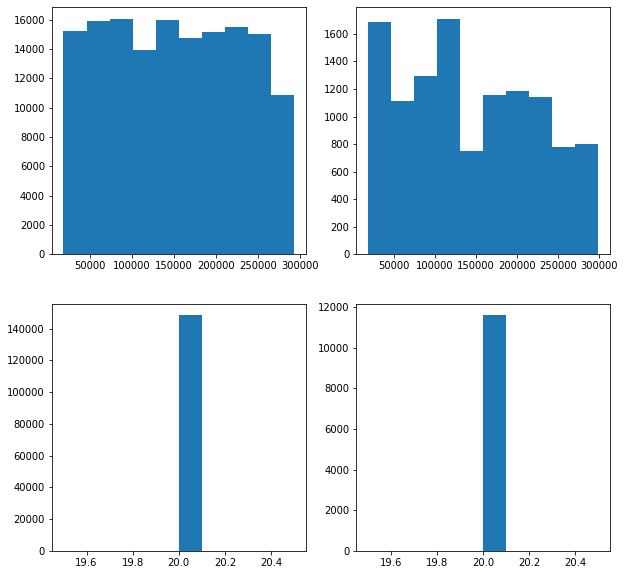

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

flist = ['ticket_id','admin_fee']

fig, ax = plt.subplots(len(flist),2)
fig.set_size_inches(5*2,5*len(flist))
for i,field in enumerate(flist):
    print(i,field)
    
    x = df[field]
    #if field == 'zip_code':
        
    
    mask = df.compliance == 0
    ax[(i,0)].hist(x[mask])
    mask = df.compliance == 1
    ax[(i,1)].hist(x[mask])
    




In [6]:
df['zip_code'] = [str(x) if len(str(x)) == 5 else str(x)[:5] if len(str(x)) > 5 else np.NaN for x in df['zip_code']]

Lets examine the violation codes. How many are there? Does there appear to be some that tend to be MORE likely to be 

In [61]:
def inspect_feature(_df, name, feature_type, bins = None):
    
    if feature_type == 'categorical':
        x = _df[name].astype(str).value_counts()
        print("%40s %6s %6s %6s %6s %6s %6s"%("Code","Count","f_c","f_nc","f_null","f_nc/f_c","flag"))

        nonc_total_fraction = np.sum(_df['compliance'] == 0) / len(_df['compliance'])
        nonc_total_ratio = np.sum(_df['compliance'] == 0) / np.sum(_df['compliance'] == 1)

        for i, count in enumerate(x):

            select  = _df[name] == x.index[i]
            nonc    = np.sum(_df['compliance'][select] == 0)
            c       = np.sum(_df['compliance'][select] == 1)
            nullval = np.sum(_df['compliance'][select].isnull())

            total = nonc+c # +nullval

            if c > 0:
                nonc_ratio = nonc/c
            else:
                nonc_ratio = .99
            
            if nonc / c > nonc_total_ratio:
                flag = 'LOOK'
            else:
                flag = ''

                
            print("%40s %6i %3.4f %3.4f %3.4f %3.4f %6s"%(x.index[i], count, c / total, nonc / total, nullval / total, nonc_ratio, flag))        
            
            
    else:
        
        #
        # does hearing date matter?
        #
        %matplotlib inline
        import matplotlib.pyplot as plt
        nonc_total_fraction = np.sum(_df['compliance'] == 0) / (np.sum(_df['compliance']==0)+np.sum(_df['compliance']==1))

        if 'date' in name:
            vals = _df[name].astype(str)
            vals = np.array([float(x[:4]) + float(x[5:7])/12.0 if x != 'nan' else 0.0 for x in vals])
        else:
            vals = _df[name].astype(float)

        # compute fraction of points in each date range that are of the three categories
        cent = (bins[1:] + bins[:-1])*0.5
        f_nonc, f_c, f_null = np.zeros(len(bins)-1), np.zeros(len(bins)-1), np.zeros(len(bins)-1)
        for i in np.arange(0,len(bins)-1):

            select = (vals< bins[i+1]) * (vals> bins[i])
            total  = np.sum(_df['compliance'][select] == 0) + np.sum(_df['compliance'][select] == 1)
            if total > 0:
                f_nonc[i] = np.sum(_df['compliance'].values[select] == 0) / total
                f_c[i]    = np.sum(_df['compliance'].values[select] == 1) / total
                f_null[i] = np.sum(_df['compliance'][select].isnull()) / total
            else:
                f_nonc[i] = 0
                f_c[i] = 0
                f_null[i] = 0




        fig,ax=plt.subplots()
        fig.set_size_inches(5,5)
        ax.step(cent, f_nonc, lw = 3, where = 'mid', label = 'Non-Compliant')
        ax.step(cent, f_c, lw = 3, where = 'mid', label = 'Compliant')
        #ax.ste
        ax.plot(ax.get_xlim(), [nonc_total_fraction]*2, lw = 3, color = 'black', ls= '--', label = 'mean_nonc_fraction')
        #ax.step(cent, f_null, lw = 3, where = 'mid', label = 'Null')
        ax.legend(loc='best')
        plt.tight_layout()
        ax.set_xlim(bins[0],bins[-1])
        
        return fig, ax
            
    return
    
#inspect_feature(df, 'violation_code', 'categorical')

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1b8ba7ac8>)

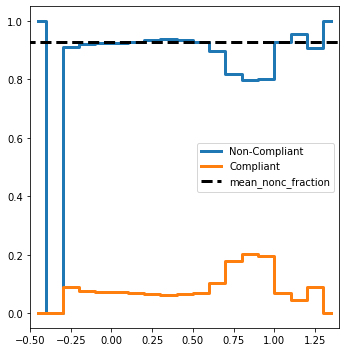

In [63]:
testdf = bd.df.copy() #pd.concat([bd.df.copy(),bd.y_train],axis=1)
testdf['diff'] = (bd.df['hearing_date'] - bd.df['ticket_issued_date'])

#testdf

inspect_feature(testdf,'diff','numerical',np.arange(-0.5,1.5,0.1))

In [29]:
#df.columns
inspect_feature(df, 'inspector_name','categorical')

                                    Code  Count    f_c   f_nc f_null f_nc/f_c   flag
                            Morris, John  17926 0.0392 0.9608 0.5448 24.5033   LOOK
                        Steele, Jonathan  13237 0.0480 0.9520 0.9013 19.8443   LOOK
                          Samaan, Neil J  12733 0.0734 0.9266 0.4602 12.6250       
                          O'Neal, Claude  11591 0.0675 0.9325 0.4354 13.8165   LOOK
                           Devaney, John  10769 0.0579 0.9421 0.5751 16.2652   LOOK
                         Sims, Martinzie   9976 0.0407 0.9593 0.8053 23.5600   LOOK
                        Sloane, Bennie J   9730 0.0619 0.9381 0.7301 15.1609   LOOK
                          Hayes, Billy J   9493 0.0769 0.9231 0.4868 12.0041       
                          Doetsch, James   7108 0.0659 0.9341 0.6389 14.1643   LOOK
                             Zizi, Josue   6587 0.0789 0.9211 0.3018 11.6817       
                         Gailes, Orbie J   6259 0.0637 0.9363 0.8137 14.686

                       Fountain, Michael    115 0.0851 0.9149 1.4468 10.7500       
                        Frinkley, Elaine    113 0.2969 0.7031 0.7656 2.3684       
                           McCary, Peggy    104 0.1167 0.8833 0.7333 7.5714       
                     Gibson, Christopher    100 0.2500 0.7500 5.2500 3.0000       
                       McDonald, Jessica     99 0.0270 0.9730 1.6757 36.0000   LOOK
                   Quarello, Christopher     99 0.0741 0.9259 0.2222 12.5000       
                            Serda, Susan     89 0.0789 0.9211 1.3421 11.6667       
                          Maples, Joseph     88 0.0213 0.9787 0.8723 46.0000   LOOK
                         Solomon, Joseph     77 0.0000 1.0000 0.9744 0.9900   LOOK
                           Rhodes, James     76 0.1449 0.8551 0.1014 5.9000       
                           Smith, Melvin     71 0.2000 0.8000 3.7333 4.0000       
                              Long, Phil     70 0.4000 0.6000 13.0000 1.5000      

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in long_scalars


                           Sanders, Glen     61 0.0526 0.9474 2.2105 18.0000   LOOK
                        Berendt, Raymond     61 0.0000 1.0000 0.0517 0.9900   LOOK
                         Shah , Kumarpal     44 0.2000 0.8000 0.4667 4.0000       
                         Woodall, Joseph     43 0.0000 1.0000 0.6538 0.9900   LOOK
                          Trzos, William     42 0.0667 0.9333 1.8000 14.0000   LOOK
                            Cox, Timothy     40 0.0909 0.9091 2.6364 10.0000       
                         Brinkley, Kevin     37 0.2400 0.7600 0.4800 3.1667       
                          Buckman, Keith     37 0.0769 0.9231 0.4231 12.0000       
                    Mitchell, Lawrence J     37 0.1667 0.8333 2.0833 5.0000       
                              Ward, Todd     35 0.0000 1.0000 3.3750 0.9900   LOOK
                         Wilcox, Valerie     34 0.2692 0.7308 0.3077 2.7143       
                            Duda, Nathan     28 0.0000 1.0000 13.0000 0.9900   LOOK

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in long_scalars


                           Sievers, Mark     10 0.1111 0.8889 0.1111 8.0000       
                            Spann, Damon      9 0.0000 1.0000 0.8000 0.9900   LOOK
                       Pacteles, Michael      8 nan nan inf 0.9900       
                         Glavac, Douglas      7 0.0000 1.0000 0.0000 0.9900   LOOK
                           Clark, Marcel      7 0.0000 1.0000 6.0000 0.9900   LOOK
                       BENNETT, MARGARET      7 0.5000 0.5000 2.5000 1.0000       
                          Dockery, James      6 nan nan inf 0.9900       
                       McClendon, Labree      6 nan nan inf 0.9900       
                         Malone, Melanie      5 0.0000 1.0000 4.0000 0.9900   LOOK
                        Pickens, William      5 0.3333 0.6667 0.6667 2.0000       
                          Miller, Ursula      5 nan nan inf 0.9900       
                             Sean, Bacon      4 nan nan inf 0.9900       
                          Burks, Colette      3 n

In [30]:
inspect_feature(df,'disposition','categorical')

                                    Code  Count    f_c   f_nc f_null f_nc/f_c   flag
                  Responsible by Default 138340 0.0382 0.9618 0.0000 25.1760   LOOK
            Not responsible by Dismissal  48695 nan nan inf 0.9900       
       Not responsible by City Dismissal  34401 nan nan inf 0.9900       
                Responsible by Admission  13701 0.2750 0.7250 0.0000 2.6361       
            Responsible by Determination   7644 0.3073 0.6927 0.0000 2.2542       
        Not responsible by Determination   6639 nan nan inf 0.9900       
                        PENDING JUDGMENT    387 nan nan inf 0.9900       
            SET-ASIDE (PENDING JUDGMENT)    304 nan nan inf 0.9900       
      Responsible (Fine Waived) by Deter    195 1.0000 0.0000 0.0000 0.0000       


/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in long_scalars


In [70]:
#
# lets look at compliance values
#  
# it looks like 59% of all values (or most of non null) are non-compliant
#    and 4.6% are compliant
# definitely some un-even classification here
# 
#
# 36% are 'not responsible'
#  ---- so... what to do with the 'not responsible'
#      a) delete these values
#            but then how do we properly predict things for test data??
#      b) keep them, but consider them 'compliant'
#
# test with both!
numnull=df['compliance'].isnull().sum()
print(df['compliance'].value_counts() / (df['compliance'].count() + numnull))
print(numnull / (df['compliance'].count() + numnull))

0.0    0.592407
1.0    0.046331
Name: compliance, dtype: float64
0.36126181553778175


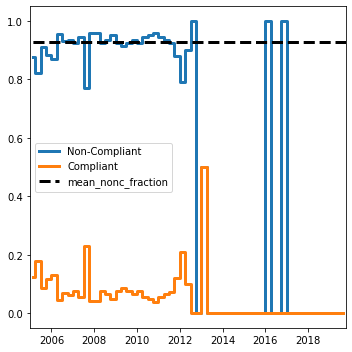

In [64]:
fig, ax = inspect_feature(df,'hearing_date','numerical',bins=np.arange(2005,2020,0.25))

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1b81ad518>)

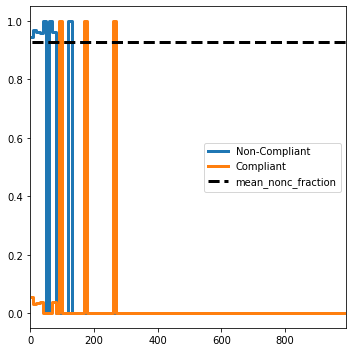

In [65]:
inspect_feature(df, 'late_fee', 'numerical',bins=np.arange(0,np.max(df['late_fee']), 10))
#df['late_fee']

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1c4b6a400>)

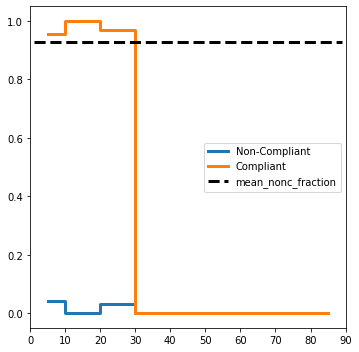

In [66]:
inspect_feature(df, 'discount_amount', 'numerical', bins = np.arange(0.0,100,10))

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe1c4040a58>)

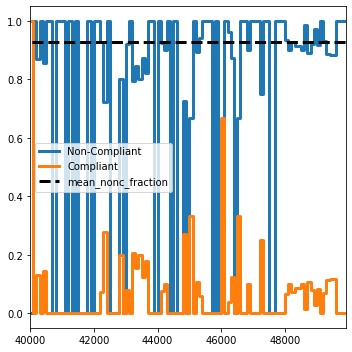

In [67]:
inspect_feature(testdf, 'zip_code','numirical',bins=np.arange(40000,50000,100))


/home/aemerick/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


[]

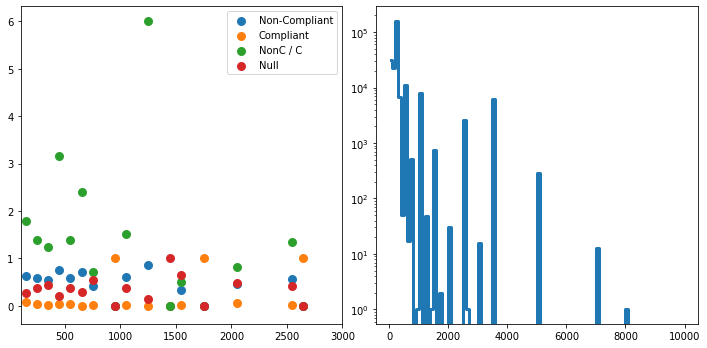

In [13]:
#
# does fine amount matter?
#
%matplotlib inline
import matplotlib.pyplot as plt

fine_amount = df['fine_amount'].astype(float).fillna(np.NaN)

# compute fraction of points in each date range that are of the three categories
bins = np.arange(0.0,10010.0 ,100.0)
cent = (bins[1:] + bins[:-1])*0.5
f_nonc, f_c, f_null = np.zeros(len(bins)-1), np.zeros(len(bins)-1), np.zeros(len(bins)-1)
count = np.zeros(np.size(f_nonc))
for i in np.arange(0,len(bins)-1):
    
    select = (fine_amount < bins[i+1]) * (fine_amount >= bins[i])
    total  = np.size(df['compliance'][select])
    count[i] = total
    if total > 0:
        f_nonc[i] = np.sum(df['compliance'][select] == 0) / total
        f_c[i]    = np.sum(df['compliance'][select] == 1) / total
        f_null[i] = np.sum(df['compliance'][select].isnull()) / total
    else:
        f_nonc[i] = np.NaN
        f_c[i] = np.NaN
        f_null[i] = np.NaN
    

    
fig,allax=plt.subplots(1,2)
fig.set_size_inches(10,5)
ax = allax[0]
ax.scatter(cent, f_nonc, lw = 3, label = 'Non-Compliant')
ax.scatter(cent, f_c, lw = 3,  label = 'Compliant')
ax.scatter(cent, f_nonc / (f_c+f_null), lw = 3,  label = 'NonC / C')
ax.scatter(cent, f_null, lw = 3, label = 'Null')
ax.legend(loc='best')
plt.tight_layout()
ax.set_xlim(100,3000)
#ax.semilogx()

ax = allax[1]
ax.step(cent, count, where = 'mid',lw=3)
ax.semilogy()



In [14]:
np.unique(fine_amount)

array([0.000e+00, 1.000e+00, 2.000e+01, 2.500e+01, 5.000e+01, 9.500e+01,
       1.000e+02, 1.250e+02, 1.500e+02, 1.600e+02, 1.700e+02, 2.000e+02,
       2.200e+02, 2.500e+02, 2.700e+02, 3.000e+02, 3.450e+02, 3.500e+02,
       3.750e+02, 4.000e+02, 4.500e+02, 5.000e+02, 6.000e+02, 6.550e+02,
       6.770e+02, 7.500e+02, 9.700e+02, 1.000e+03, 1.030e+03, 1.200e+03,
       1.250e+03, 1.470e+03, 1.500e+03, 1.750e+03, 2.000e+03, 2.500e+03,
       2.695e+03, 3.000e+03, 3.500e+03, 5.000e+03, 7.000e+03, 8.000e+03,
       1.000e+04,       nan])